# Bayesian Optimal Experimental Design

In [1]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.facecolor'] = 'beige'
plt.rcParams['figure.dpi'] = 300

In [2]:
def runge_kutta_step(X,t,rhs,dt):
    """
    One step of the standard Runge-Kutta fourth order. You can find nice
    implementations in scipy, for example, but I like being able
    to run many trajectories in parallel and do a few other things.
    
    See runge_kutta_solve for the actual end-user call.
    """
    k1=rhs(X,t)
    k2=rhs(X+0.5*dt*k1,t+0.5*dt)
    k3=rhs(X+0.5*dt*k2,t+0.5*dt)
    k4=rhs(X+dt*k3,t+dt)
    return( (dt/6.)*(k1+2*k2+2*k3+k4) )

def runge_kutta_step_with_params(X,params,t,rhs,dt):
    """
    One step of the standard Runge-Kutta fourth order.
    This assumes rhs can be called like rhs(X,params,t)
    """
    k1=rhs(X,params,t)
    k2=rhs(X+0.5*dt*k1,params,t+0.5*dt)
    k3=rhs(X+0.5*dt*k2,params,t+0.5*dt)
    k4=rhs(X+dt*k3,params,t+dt)
    return( (dt/6.)*(k1+2*k2+2*k3+k4) )

def runge_kutta_solve(X0,rhs,T,nsteps,params=None,progress_bar=False):
    """
    Solve the differential equation dX/dt=rhs(X,t), for 'nsteps' time steps up to time T,
    with initial value X(t=0)=X0.
    
    Here X0 can have ANY shape as an array, and rhs(X,t) must return the same shape.
    
    This is convenient in case you want to, say, do many trajectories in parallel,
    or reserve one index for the particle number, etc. You do not need to assume
    X to be a 1d array, as you would have to do for some other Runge-Kutta implementations.
    It is also nice to split the positions and velocities, e.g. X[0,:] for the positions
    of all particles, and X[1,:] for the velocities.
    
    Returns: Xs,ts
    
    where the shape of the solution Xs is the same as that of X, except we add another dimension
    at the end, of size 'nsteps'. 'ts' just is a 1d array denoting the time steps for
    the solution.
    
    Plotting the solution may work like this, if X was a 1d array:
    
    plt.plot(ts,Xs[5]) # Note that Xs[5] is the same as Xs[5,:]
    
    ...or like this, if e.g. X[1,:] were all the velocities of all particles:
    
    plt.plot(ts,Xs[1,3]) # plotting velocity of particle number 3: Xs[1,3] is the same as Xs[1,3,:]
    
    (code by Florian Marquardt 2020)
    """
    dt=T/nsteps
    if isinstance(X0,list):
        X0=np.array(X0)
    X=np.array(X0,dtype=X0.dtype)
    Xs=np.zeros(np.shape(X0)+(nsteps,),dtype=X0.dtype) # to store all the results: add 'nsteps' dimension
    if progress_bar:
        import tqdm
        my_range=tqdm.trange(nsteps)
    else:
        my_range=range(nsteps)
    for j in my_range:
        if params is None:
            X+=runge_kutta_step(X,j*dt,rhs,dt)
        else:
            X+=runge_kutta_step_with_params(X,params,j*dt,rhs,dt)
        Xs[...,j]=X # store result (... means: we don't care how many dimensions there are!)
    ts=dt*(np.array(range(nsteps))+1) # all time points
    return(Xs,ts)


In [3]:
def force_scattering(dx,dy):
    """
    Return force from a scattering centre located at the origin (0,0).
    """
    r2=dx**2+dy**2
    strength=0.2
    return strength*dx/(1+r2),strength*dy/(1+r2)

def fluctuating_force(shape):
    """
    Return a fluctuating force. This is a bit of a hack,
    as we rely on a global variable that contains information
    about the strength (which must be scaled according to the
    time-step-size). 
    
    shape is the shape of the array we are supposed to return,
    which will be filled with Gaussian random numbers.
    
    This represents a white noise force
    """
    global fluctuation_strength
    return fluctuation_strength*np.random.randn(*shape)
    
def rhs_scattering(X,params,t):
    """
    Right-hand-side of equation of motion, for a test particle subject to
    a scattering potential.
    
    X[0,...]: x-coordinate
    X[1,...]: y-coordinate
    X[2,...]: x-velocity
    X[3,...]: y-velocity
    
    '...' stands for all the batch dimensions (may be used to sweep over
    different initial conditions and different values of the parameters)
    
    params[0,...]: location of scattering potential along the y-direction
    """
    force_x,force_y = force_scattering(X[0],X[1]-params[0])
    fluctuations = fluctuating_force(shape=[2]+list(X.shape)[1:])
    return np.array([X[2],X[3],force_x+fluctuations[0],force_y+fluctuations[1]])


In [4]:
# test: run a range of trajectories, all starting with different angles

def trajectory_bunch(phi_value):
    global fluctuation_strength # used inside rhs_scattering -> flucutating_force
    
    T=10.0 # total time for a trajectory
    velocity=1.0 # initial velocity

    N_phi=150 # number of starting angles
    #phi=np.linspace(-np.pi/4,np.pi/4,N_phi)
    phi=np.full(N_phi,phi_value)

    nsteps=100 # number of time steps

    dt=T/nsteps # size of time step
    fluctuation_strength = .1 / np.sqrt(dt) # size of fluctuating force acting on particle

    # initial conditions:
    X0=np.zeros([4,N_phi])

    X0[0,...]=-5.0 # initial x
    X0[1,...]=0.0 # initial y
    X0[2,...]=velocity*np.cos(phi) # v_x
    X0[3,...]=velocity*np.sin(phi) # v_y

    # location of scattering centre
    params=np.array([2.0])

    Xs,ts=runge_kutta_solve(X0,rhs_scattering,T,nsteps,params=params,progress_bar=True)
    
    return Xs

100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 13150.76it/s]


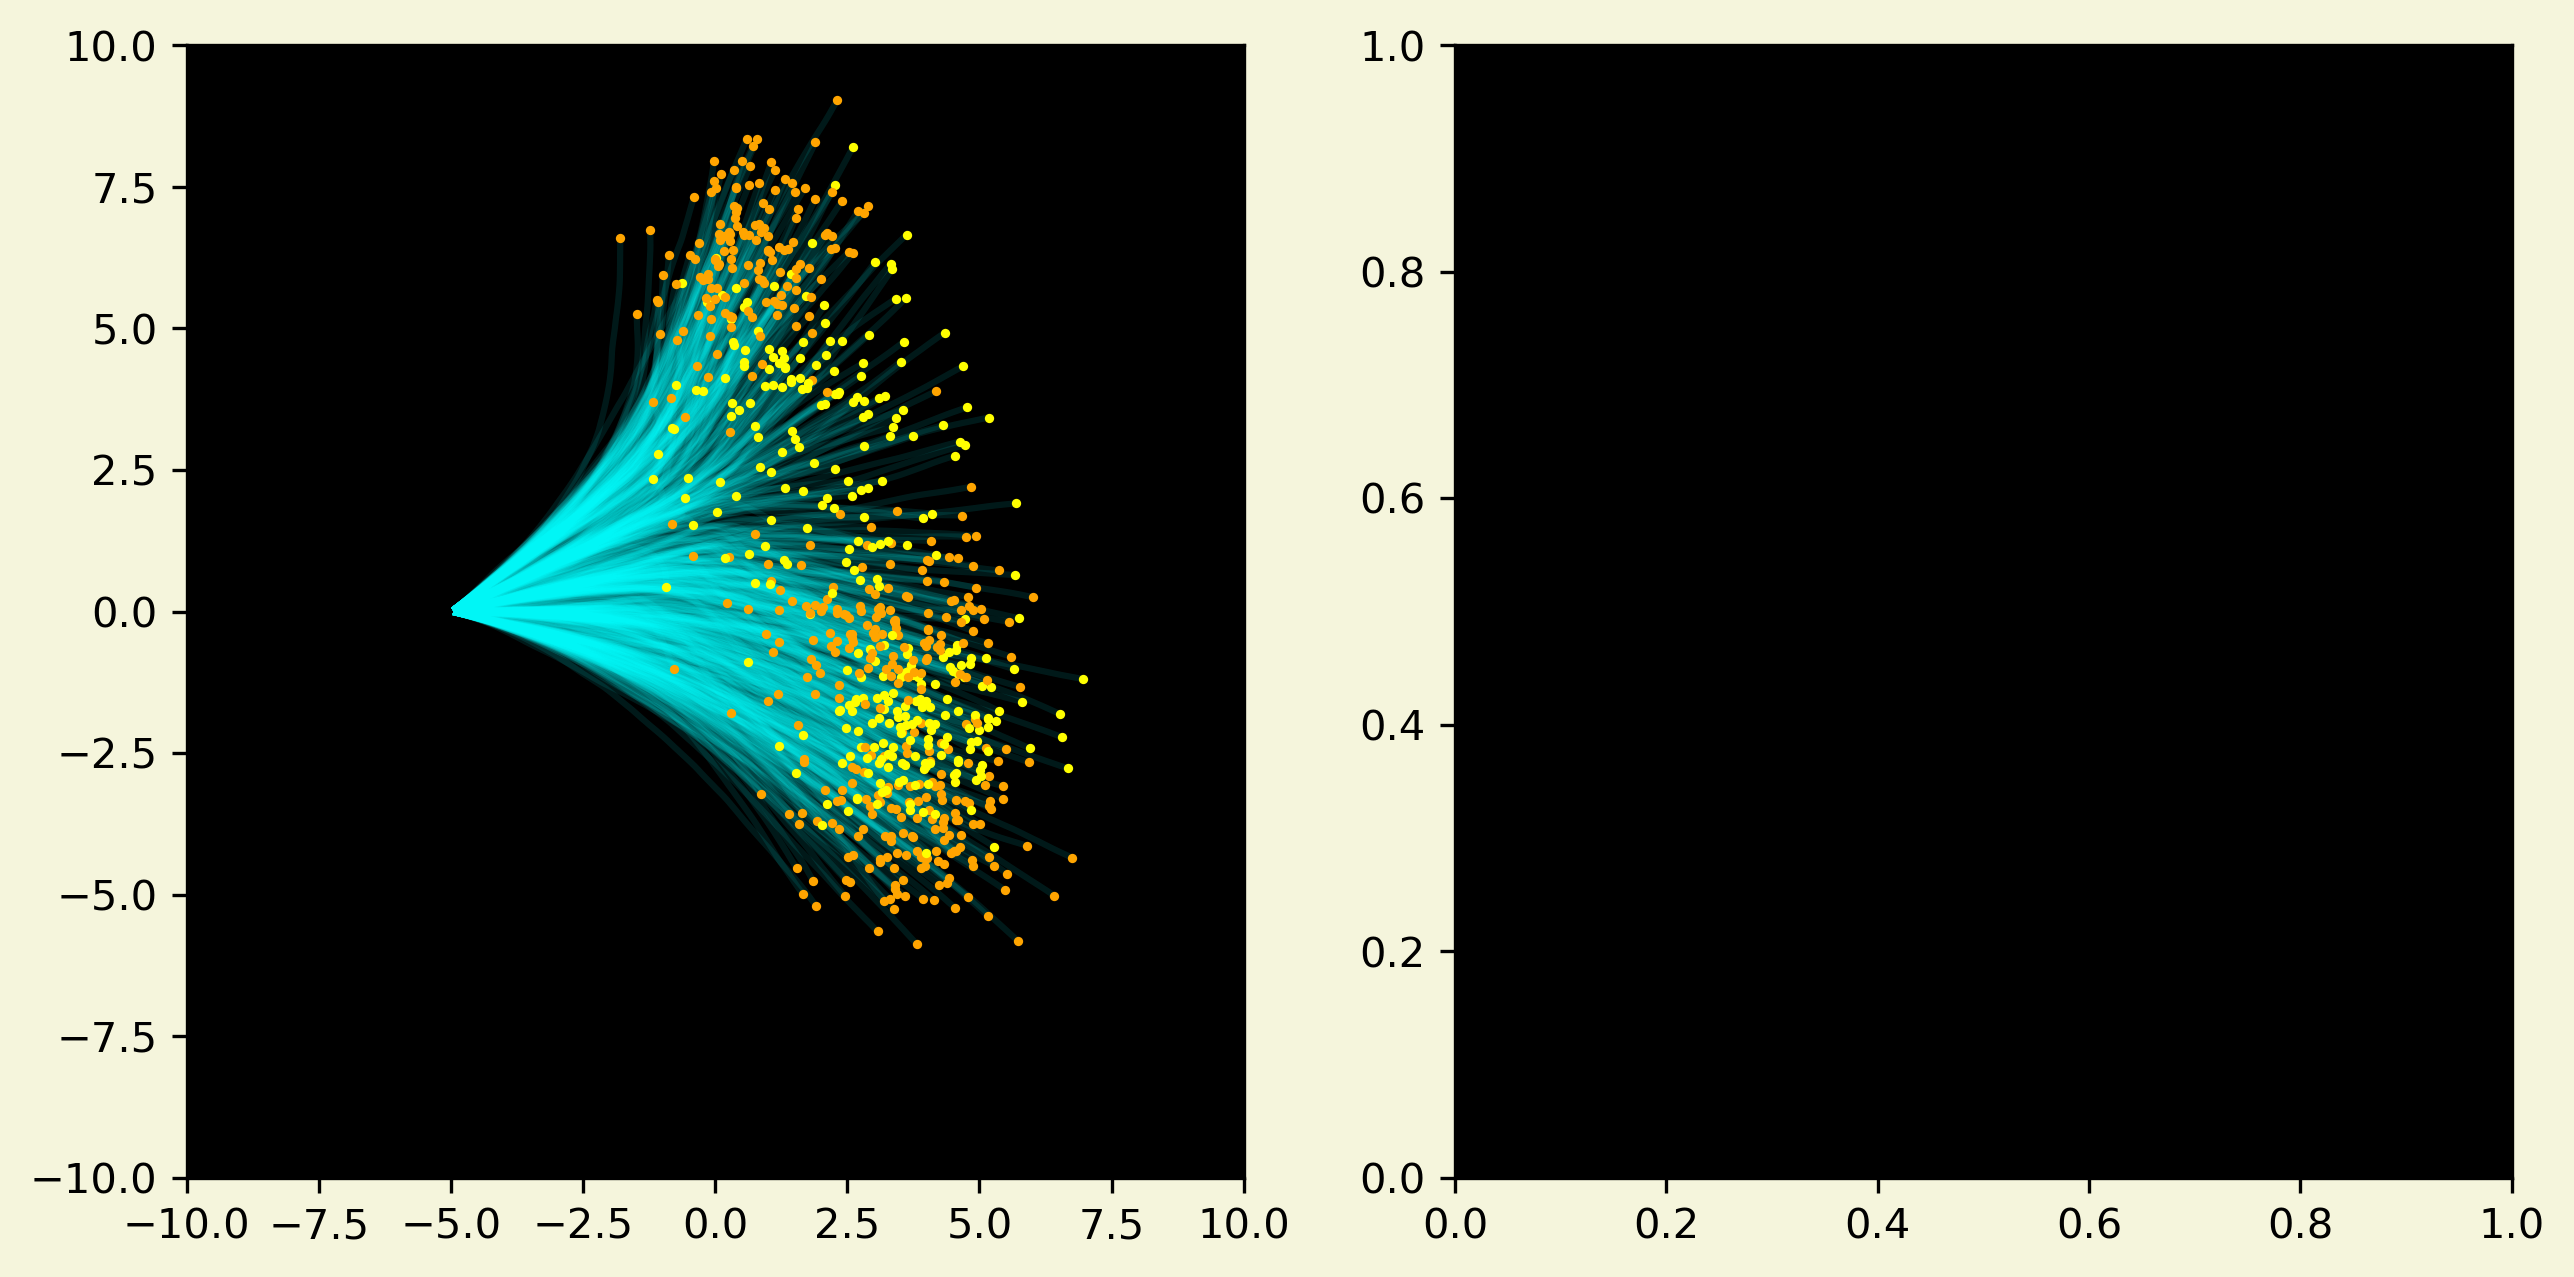

In [5]:
fig,ax=plt.subplots(ncols=2,figsize=(10,5),dpi=300)
for phi_value,color in zip([-0.2,-0.0,0.2,0.4,0.6],
                           ['orange','yellow','orange','yellow','orange']): # plot all starting angles:
    Xs=trajectory_bunch(phi_value)
    N_trajs=Xs.shape[1]
    for idx in range(N_trajs):
        ax[0].plot(Xs[0,idx],Xs[1,idx],color='cyan',alpha=0.1)
    ax[0].scatter(Xs[0,:,-1],Xs[1,:,-1],color=color,s=5,linewidth=0,zorder=10)
ax[0].set_facecolor('black')
ax[0].set_xlim(-10,10)
ax[0].set_ylim(-10,10)
ax[1].set_facecolor('black')
plt.show()

In [6]:
# now prepare Bayes updates:
# collect full statistics, for all angles and all possible parameter values
# this is still relatively efficient, because all trajectories are run in parallel
# ...it takes some time... (more than a minute on a Mac M1)

T=10.0 # total time for a trajectory
velocity=1.0 # initial velocity

N_phi=60 # number of starting angles (thus: sample trajectories)
N_random_samples=2000 # number of random trajectory samples per (phi,lambda)-combination
N_lambda=50 # number of possible positions of scattering centre
lambda_max=3.0 # maximum value of lambda

nsteps=30 # number of time steps

dt=T/nsteps # size of time step
fluctuation_strength = .1 / np.sqrt(dt) # size of fluctuating force acting on particle

# angles
phi_max=np.pi/4
phi=np.linspace(-phi_max,phi_max,N_phi)

# location of scattering centre
params=np.zeros([1,N_phi,N_lambda,N_random_samples])
lambda_values=np.linspace(-lambda_max,lambda_max,N_lambda)
params[0,:,:,:]=lambda_values[None,:,None]

# initial conditions:
X0=np.zeros([4,N_phi,N_lambda,N_random_samples])

X0[0,...]=-5.0 # initial x
X0[1,...]=0.0 # initial y
X0[2,...]=velocity*np.cos(phi)[:,None,None] # v_x
X0[3,...]=velocity*np.sin(phi)[:,None,None] # v_y

Xs,ts=runge_kutta_solve(X0,rhs_scattering,T,nsteps,params=params,progress_bar=True)

100%|███████████████████████████████████████████████████████| 30/30 [01:25<00:00,  2.84s/it]


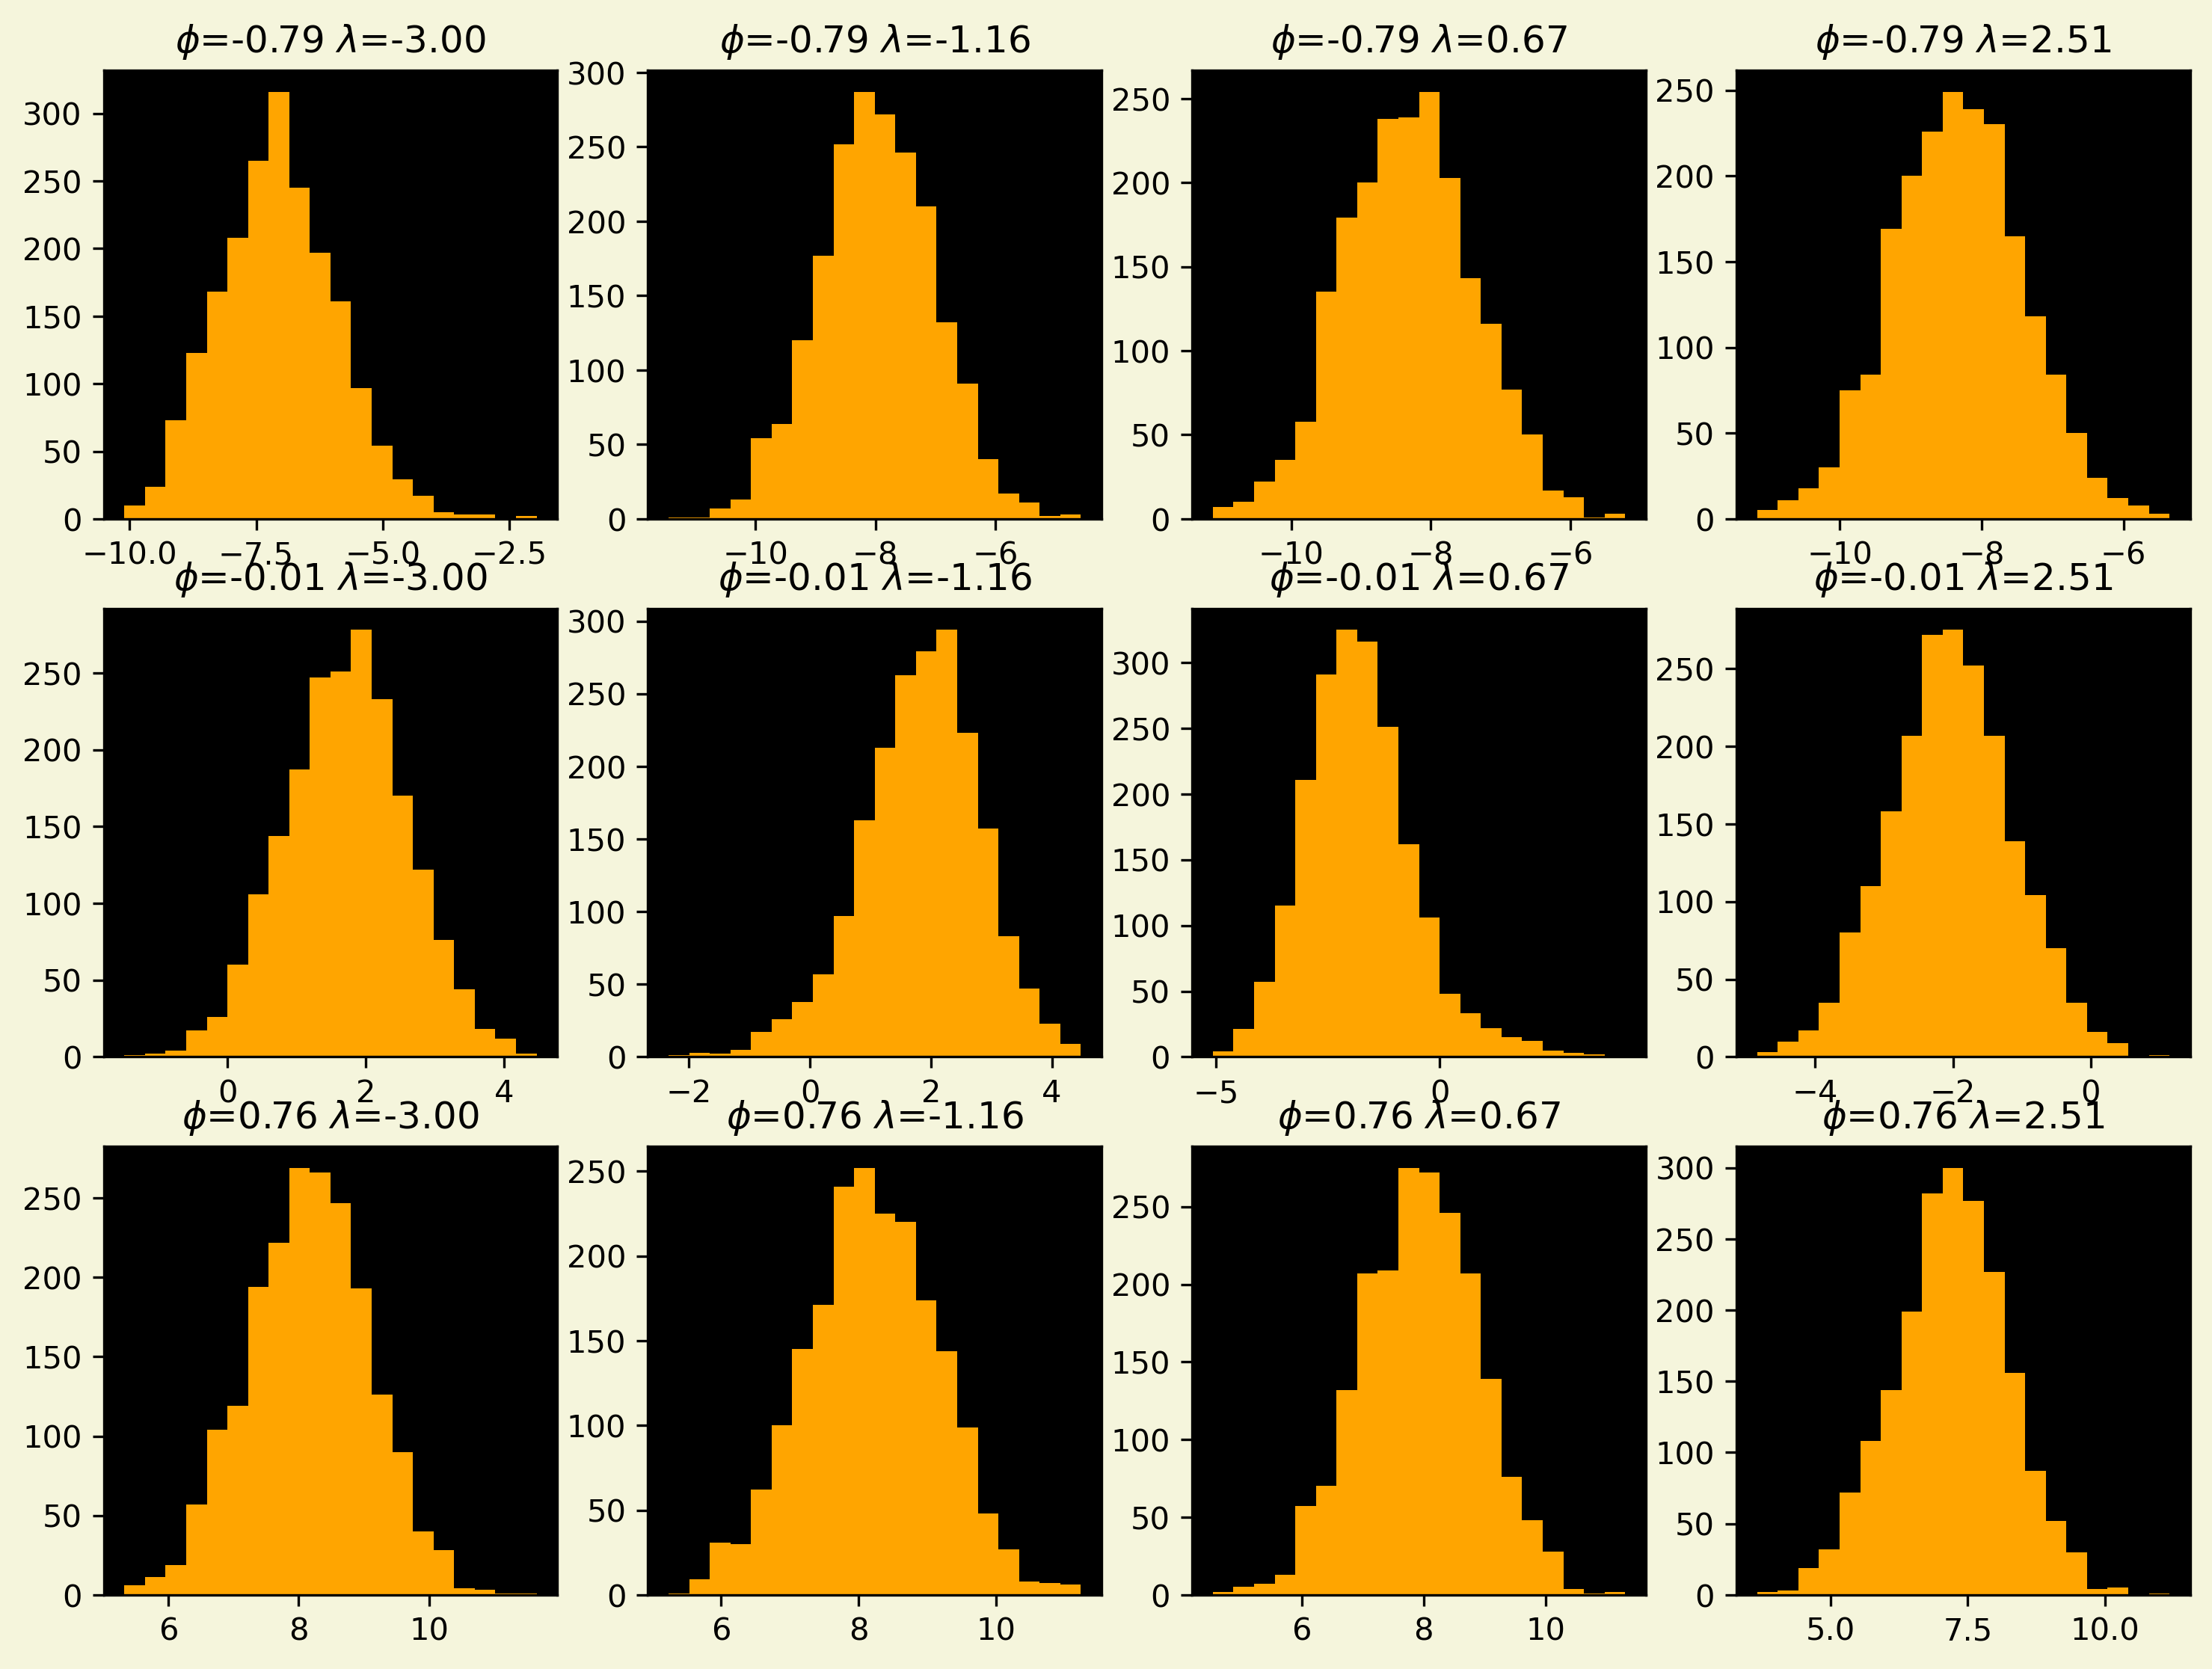

In [7]:
# plot resulting model statistics
# for a few alpha and lambda

n_phi_plots=3
n_lambda_plots=4

fig,ax=plt.subplots(nrows=n_phi_plots,ncols=n_lambda_plots,figsize=[3*n_lambda_plots,3*n_phi_plots])

phi_data_indices = np.arange(n_phi_plots)*(int(N_phi/(n_phi_plots-1))-1)
lambda_data_indices = np.arange(n_lambda_plots)*(int(N_lambda/(n_lambda_plots-1))-1)

for idx_phi_panel,idx_phi_data in enumerate(phi_data_indices):
    for idx_lambda_panel,idx_lambda_data in enumerate(lambda_data_indices):
        ax[idx_phi_panel,idx_lambda_panel].set_facecolor('black')
        ax[idx_phi_panel,idx_lambda_panel].hist(Xs[1,idx_phi_data,idx_lambda_data,:,-1],
                                                color='orange',bins=20)
        ax[idx_phi_panel,idx_lambda_panel].set_title(
            f"$\phi$={phi[idx_phi_data]:.2f} $\lambda$={lambda_values[idx_lambda_data]:.2f}")

In [8]:
# obtain P(y|lambda,x) --- the model probability for a measurement value y,
# given the msmt choice x (here: angle phi) and the parameter lambda (here: scattering centre location)
#
# unfortunately, np.histogram works only on one 1D array at a time...
# here we make our own histogram...looping along the y-direction, but 
# treating all (phi,lambda) in parallel. Turns out to be very efficient!

N_y_bins=50
y_bins=np.linspace(-14.,14.,N_y_bins+1)

P_model=np.zeros([N_phi,N_lambda,N_y_bins])

for idx_y_bin in range(N_y_bins):
    inside_bin=(Xs[1,...,-1]>=y_bins[idx_y_bin])*(Xs[1,...,-1]<y_bins[idx_y_bin+1])
    P_model[...,idx_y_bin]=np.sum(inside_bin,axis=-1) # count number of y-samples inside bin

# still normalize:
P_model/=N_random_samples



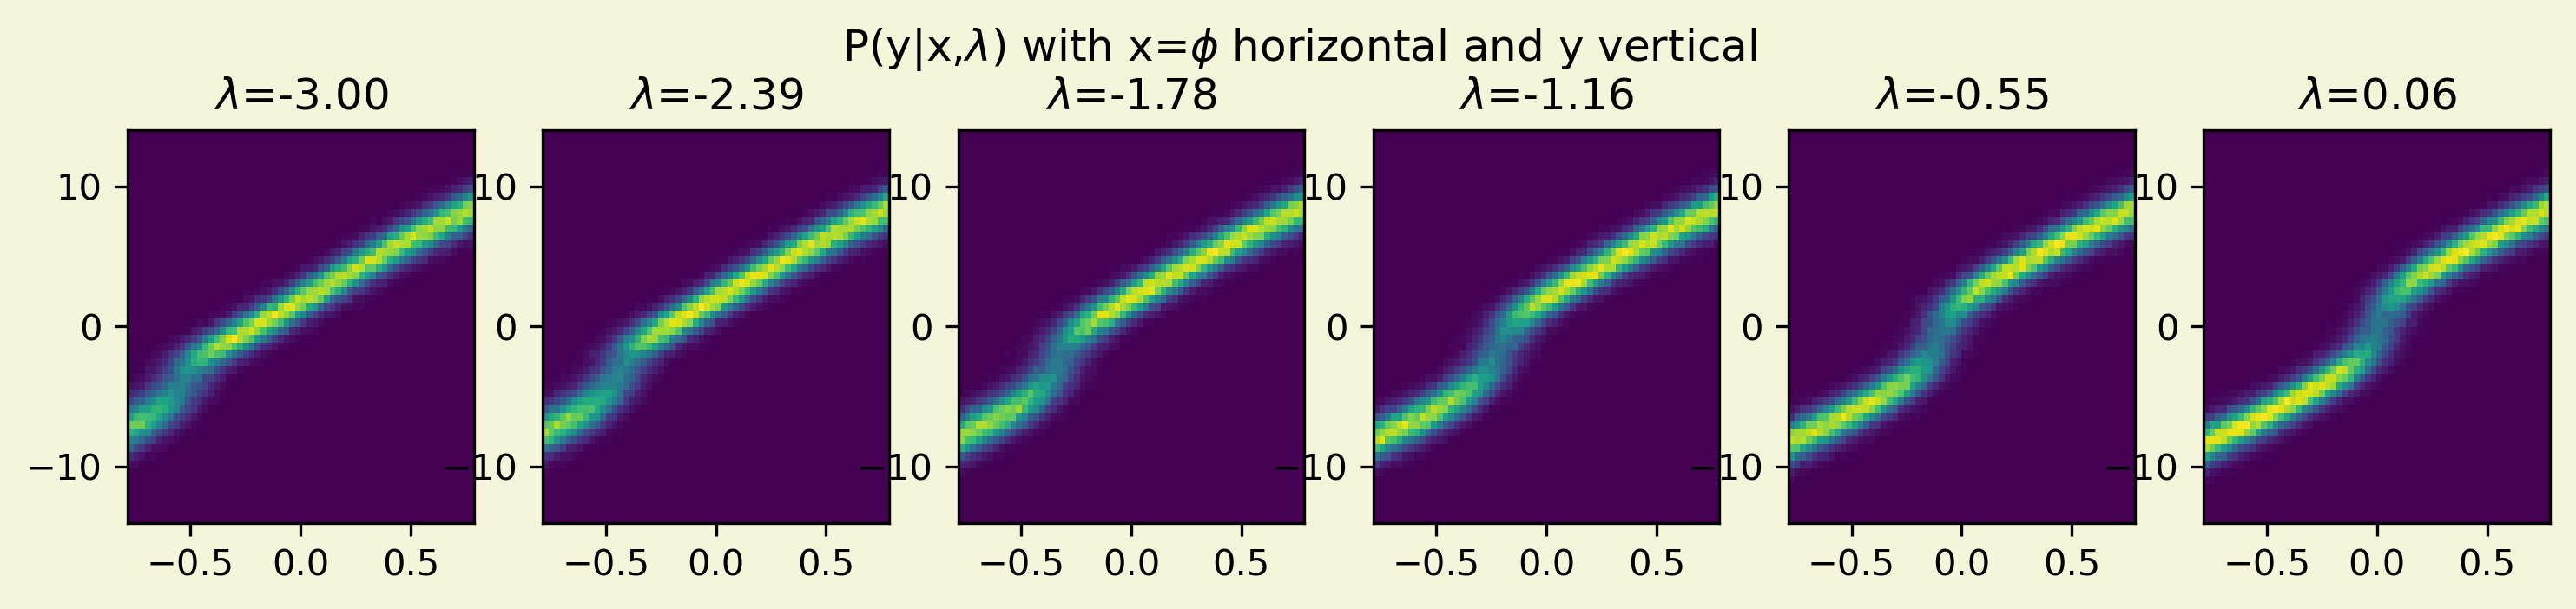

In [9]:
# now plot
fig,ax=plt.subplots(ncols=6,figsize=(12,2))
plt.suptitle("P(y|x,$\lambda$) with x=$\phi$ horizontal and y vertical",y=1.08)

for idx in range(6):
    ax[idx].imshow(P_model[:,idx*5,:].T,origin='lower',extent=(-phi_max,phi_max,y_bins[0],y_bins[-1]))
    ax[idx].axis('auto')
    ax[idx].set_title(f"$\lambda$={lambda_values[idx*5]:.2f}")
plt.show()

In [10]:
def Bayes_update(P_lambda_prior, P_model):
    """
    Perform one Bayes update, for arbitrary measurement choices and measurement results.
    
    Returns the updated lambda-distribution, but still also dependent
    on msmt choice and msmt result.
    
    P_model represents P(y|x,lambda),
    where in our case
        y=msmt result (our case: y-coordinate after scattering)
        x=msmt choice (our case: phi = angle of initial starting condition)
        lambda (our case: position of scatterer)
    
    P_model.shape=[N_x,N_lambda,N_y_bins]
    """
    # still unnormalized:
    P_update = P_model * P_lambda_prior[None,:,None] # first and last indices are msmt choice and msmt result!
    # little hack: for results where normalization would give 0 (thus: impossible to obtain)
    # we simply set one of the lambda-entries to 1. This avoids problems down the line, but
    # cannot change the result.
    normalization = np.sum(P_update,axis=1)[:,None,:]
    P_update[:,0,:] += (normalization[:,0,:]==0)
    normalization[:,0,:] += (normalization[:,0,:]==0)
    return P_update / normalization

def expected_information_gain(P_lambda_posterior,P_lambda_prior,P_model):
    """
    Calculate the expected information gain, as a function of msmt choice.
    
    P_lambda_posterior is of shape [N_phi,N_lambda,N_y_bins], so it still
    depends on msmt choice x (=phi in our case) and msmt result y.
    
    P_lambda_prior is simply of shape [N_lambda].
    
    P_model.shape = [N_x,N_lambda,N_y_bins], which is P(y|x,lambda)
    
    This calculates the entropy reduction of the lambda-distribution,
    for each combination of msmt choice and result, and then
    averages it over the msmt result.
    """
    SMALL_NUMBER=1e-12
    
    # entropy of prior lambda distribution:
    # add some small number inside log to avoid log(0) blowing up (it would not contribute anyway)
    H_prior=-np.sum( P_lambda_prior * np.log(P_lambda_prior + SMALL_NUMBER) ) # a number
    
    # calculate H(lambda|Y(x)=y) as a function of x and y:
    H_posterior = -np.sum( P_lambda_posterior * np.log(P_lambda_posterior + SMALL_NUMBER) , axis=1) 
    # H_posterior.shape = [N_phi,N_y_bins]
    
    # obtain P(Y(x)=y) from averaging P(Y=y|lambda) over P_prior(lambda):
    P_y = np.sum( P_model*P_lambda_prior[None,:,None], axis=1 ) # shape [N_phi,N_y_bins]
    
    # average H(lambda|Y(x)=y) over y:
    H_posterior_avg = np.sum( H_posterior *  P_y , axis=1) # shape [N_phi]
    
    # the expected information gain: (as a function of x)
    return H_prior - H_posterior_avg
    

In [11]:
def sample(probs):
    """
    Sample from a probability distribution 'probs' (1D array). Return
    index of the bin that is selected randomly according to this distribution.
    """
    prob_cum = np.cumsum(probs)
    p = np.random.uniform()
    return np.argmin(prob_cum<p) # random index, selected according to the probability distribution


In [12]:
def measure_and_update(idx_chosen_msmt,idx_lambda_star,P_lambda_posterior,P_model):
    """
    Perform a measurement, i.e. sample the measurement result, and
    return the updated lambda distribution!
    
    idx_chosen_msmt: index of the chosen msmt parameter
    idx_lambda_star: index of the true lambda value 
        (hidden from the Bayes machinery, of course, but used
        to sample the msmt result)
    P_lambda_posterior: the previously computed posterior distribution of lambda,
        see Bayes_update: P(lambda|x,y)
    P_model: the previously computed model for the measurements P(y|lambda,x)
    
    Returns:
    
    P_lambda_new, idx_y
        the new lambda distribution, and the randomly selected msmt outcome (as index)
    """
    P_y=P_model[idx_chosen_msmt,idx_lambda_star,:]

    idx_y = sample(P_y) # random msmt result

    # the new lambda distribution:
    return P_lambda_posterior[idx_chosen_msmt,:,idx_y], idx_y

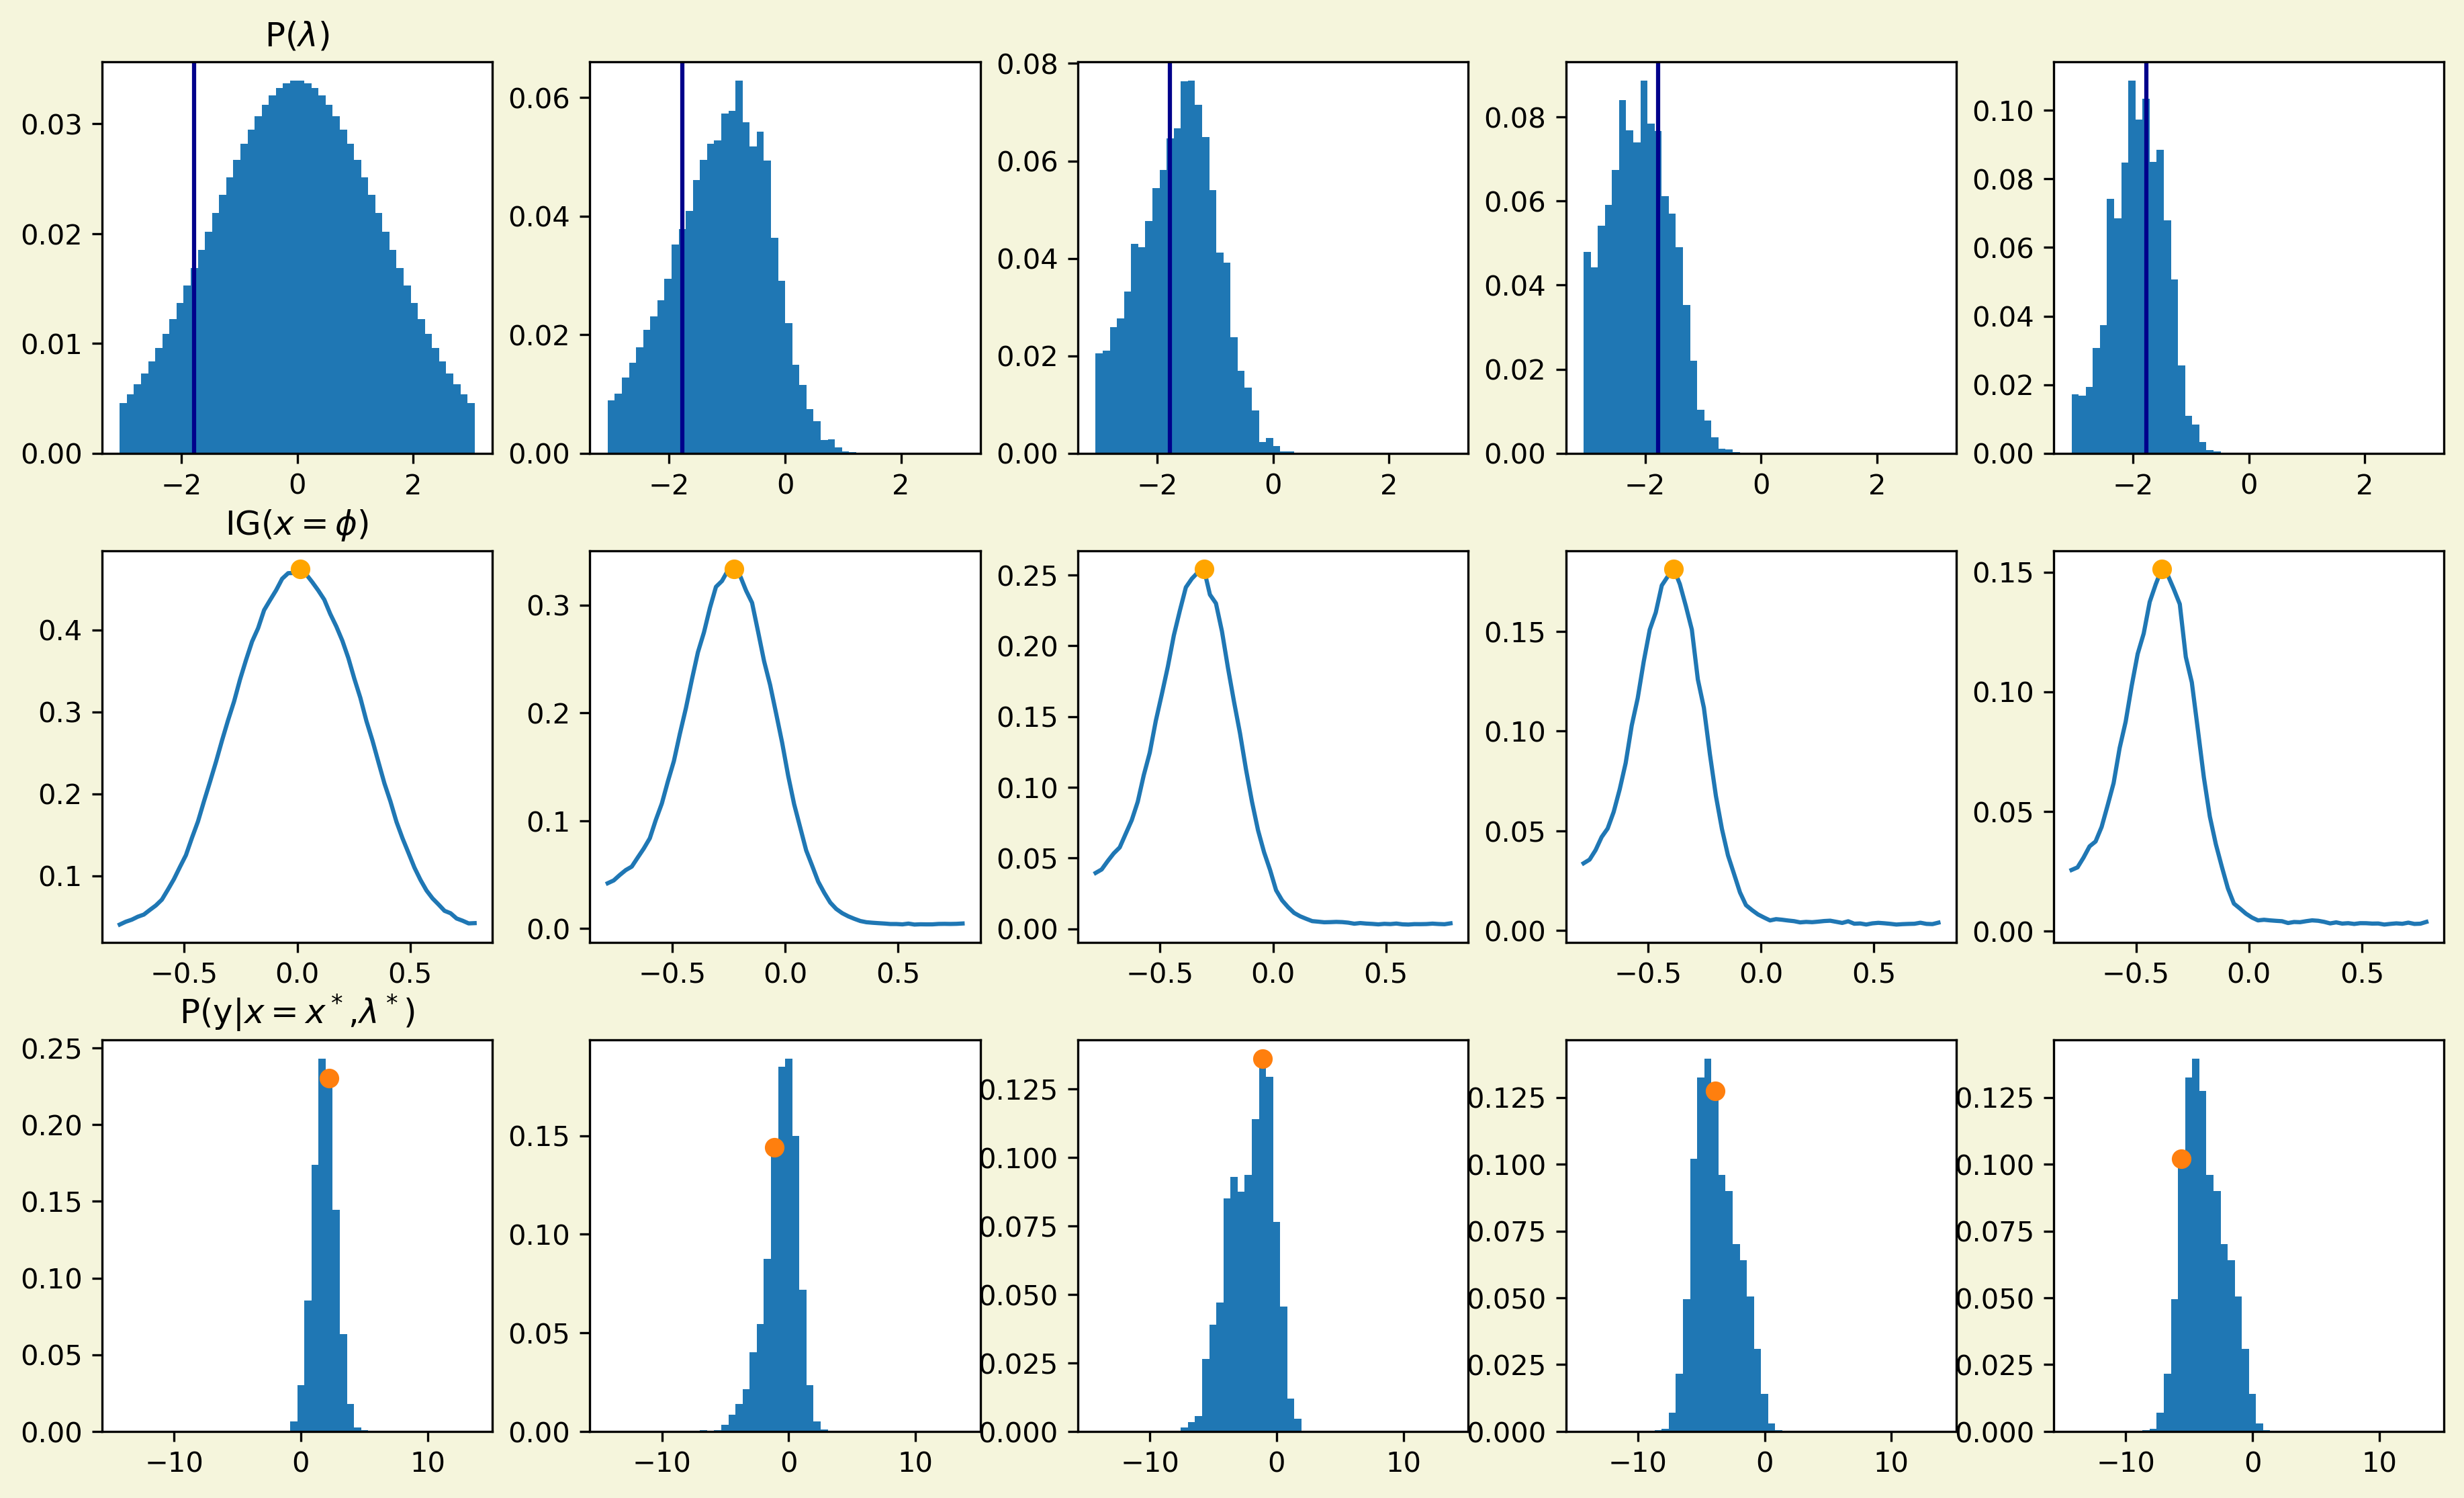

In [13]:
# number of measurements we want to do:
num_measurements=5

fig,ax=plt.subplots(ncols=num_measurements,nrows=3,figsize=[num_measurements*3,3*3])

# our prior distribution
#P_lambda_prior=np.full(N_lambda,1/N_lambda) # uniform initial distribution over lambda
P_lambda_prior=np.exp(-2*(lambda_values/lambda_max)**2)
P_lambda_prior/=np.sum(P_lambda_prior)

# the true value of lambda (hidden from us, of course!)
idx_lambda_star = 10

for measurement_step in range(num_measurements):
    # Calculate hypothetical Bayes update:
    P_lambda_posterior = Bayes_update(P_lambda_prior,P_model) # posterior for ANY msmt choice and msmt result

    # plot prior:
    ax[0,measurement_step].bar(x=lambda_values,height=P_lambda_prior,width=lambda_values[1]-lambda_values[0])
    if measurement_step==0:
        ax[0,measurement_step].set_title("P($\lambda$)")
    ax[0,measurement_step].axvline(lambda_values[idx_lambda_star],color='darkblue')
    
    # from that: the expected information gain (still a function of msmt choice!):
    information_gain = expected_information_gain(P_lambda_posterior,P_lambda_prior,P_model)
    
    # select the 'best' measurement (highest expected information gain)
    idx_chosen_msmt = np.argmax(information_gain)

    # plot information gain
    ax[1,measurement_step].plot(phi,information_gain)
    if measurement_step==0:
        ax[1,measurement_step].set_title("IG($x=\phi$)")
    ax[1,measurement_step].scatter([phi[idx_chosen_msmt]],[information_gain[idx_chosen_msmt]],
                                  color='orange',zorder=10)
    
    # Now select a measurement result randomly, from the model distribution for the
    # true value lambda_star, for this selected measurement. Use this to update
    # our lambda distribution:
    P_lambda_prior,idx_y = measure_and_update(idx_chosen_msmt,idx_lambda_star,P_lambda_posterior,P_model)

    # plot P(y|lambda_true,x):
    ax[2,measurement_step].bar(x=y_bins[:-1],
                               width=y_bins[1]-y_bins[0],
                               height=P_model[idx_chosen_msmt,idx_lambda_star,:])
    if measurement_step==0:
        ax[2,measurement_step].set_title("P(y|$x=x^*$,$\lambda^*$)")
    ax[2,measurement_step].scatter([y_bins[idx_y]],[P_model[idx_chosen_msmt,idx_lambda_star,idx_y]],
                                  zorder=10)
plt.subplots_adjust(wspace=0.25,hspace=0.25)